In [2]:
from IPython.display import Image

import pprint
import json

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


In [3]:
from tabulate import tabulate
def DisplayMatrix(M):
    print(tabulate(M, headers='keys', tablefmt='double_grid'))

In [4]:
'''
In order to see how we can work with models that we've previously serialized out to disk, 
I'm going to start off on a brand new notebook.

Let's load in our insurance_processed.csv file. Here is our processed_data, and we'll use this to test the
models that we have previously serialized. 

This is the regression model that we use to predict insurance charges for individuals.
'''
processed_data = pd.read_csv('./datasets//insurance_processed.csv')
DisplayMatrix(processed_data.head())

╔════╦═══════════╦═══════════╦════════════╦═══════╦══════════╦════════════════════╦════════════════════╦════════════════════╦════════════════════╦═══════════╗
║    ║       age ║       bmi ║   children ║   sex ║   smoker ║   region_northeast ║   region_northwest ║   region_southeast ║   region_southwest ║   charges ║
╠════╬═══════════╬═══════════╬════════════╬═══════╬══════════╬════════════════════╬════════════════════╬════════════════════╬════════════════════╬═══════════╣
║  0 ║ -1.43876  ║ -0.45332  ║ -0.908614  ║     0 ║        1 ║                  0 ║                  0 ║                  0 ║                  1 ║  16884.9  ║
╠════╬═══════════╬═══════════╬════════════╬═══════╬══════════╬════════════════════╬════════════════════╬════════════════════╬════════════════════╬═══════════╣
║  1 ║ -1.50997  ║  0.509621 ║ -0.0787672 ║     1 ║        0 ║                  0 ║                  0 ║                  1 ║                  0 ║   1725.55 ║
╠════╬═══════════╬═══════════╬════════════╬═══

In [13]:
'''
Now that we have the data loaded in, let's split the data into processed_features and the target, 
that is, the insurance charges, and we'll also split the data as we did before, using train_test_split.
'''
processed_features = processed_data.drop('charges', axis=1)
target = processed_data[['charges']]
X_train, X_test, y_train, y_test = train_test_split(processed_features, target, test_size=0.2, random_state=1)

In [14]:
'''
 Now, if you remember, we had saved out the architecture or the configuration of the model in this JSON file. 
 So I'm going to read in the configuration of this model and store this in the model_json variable. 
'''
with open('./models/elu_64_early_stopping_config.json', 'r') as f:
    model_json = json.load(f)

In [15]:
'''
Let's take a look at the model_json, and here is the model that we had previously serialized. 
This is the model that we had built previously using the sequential API, and this model uses a dropout layer. 

This JSON file only contains the specifications of the model's architecture and not the weights of the model.
'''
pprint.pprint(model_json)

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'layers': [{'class_name': 'InputLayer',
                        'config': {'batch_input_shape': [None, 9],
                                   'dtype': 'float32',
                                   'name': 'dense_9_input',
                                   'ragged': False,
                                   'sparse': False}},
                       {'class_name': 'Dense',
                        'config': {'activation': 'elu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 9],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'dtype': 'float32',
                                   'kernel_c

In [16]:
'''
Go ahead and recreate the model's architecture using model_from_json, available in tf.keras.models. 

This gives us a model object, and if you take a look at the summary of the model, 
you can see the layers of the model, as well as the dropout.

This is the same model that we had set up earlier. 
'''

model=tf.keras.models.model_from_json(json.dumps(model_json))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                320       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


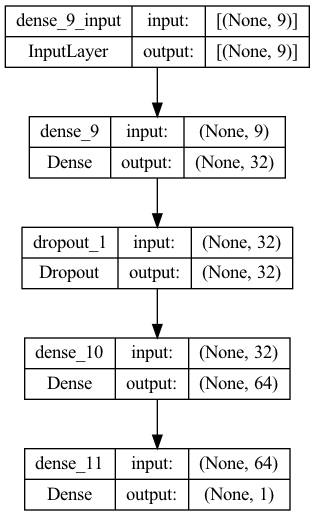

In [17]:
'''
Now you can plot this model and visualize this model to see that it's indeed the same. 
'''
tf.keras.utils.plot_model(model, 'model_elu_64_early_stopping.png',show_shapes=True)

In [18]:
'''
We've instantiated our model object using the JSON configuration, but the model weights haven't been loaded in. 
So if you try and use this model for prediction, you won't really get a good result. 

Let's run prediction using this model and calculate the r2_score, and you can see it's a negative value.
'''
y_pred_after_loading = model.predict(X_test)
print(r2_score(y_test, y_pred_after_loading))

9/9 [==============================] - 0s 900us/step
-1.2083689164638058


In [19]:
'''
The weights of this model have only their initial values. 
We need to load in the trained weights, and we'll do this using model.load_weights. 

The weights of this model are stored within a subdirectory under my_models, and these weights 
will be loaded into our model configuration or architecture. 

This is the checkpoint format in TensorFlow.
'''

model.load_weights('./models/elu_64_early_stopping_weights.h5')

In [21]:

'''
If we now call predict on the test data, that is, after having loaded in the weights, 
you'll find that the r2_score of this model matches the r2_score that we saw earlier.
'''
y_pred_after_loading = model.predict(X_test)
print(r2_score(y_test, y_pred_after_loading))

9/9 [==============================] - 0s 958us/step
0.8369305583435344


In [22]:
'''
It's more convenient, though, to work with the TensorFlow save model format, which stores the model's architecture, 
as well as the weights. 

Use tf.keras.models.load_model. The input argument here is the directory where we've stored out our 
TensorFlow model in the same model format.

Take a look at the summary of this loaded model. We have the architecture of the model that looks the same.

In addition to the architecture of the model, the weights of the model have also been initialized.
'''

loaded_model=tf.keras.models.load_model('./models/elu_64_early_stopping')
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                320       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


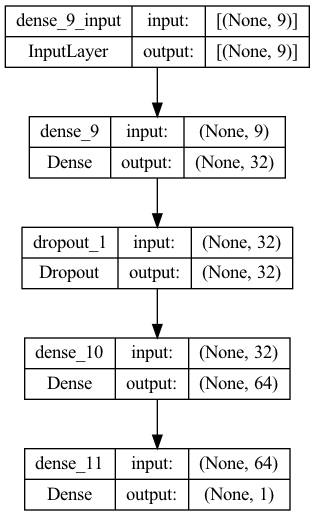

In [23]:
'''
Now you can plot this model and visualize this model to see that it's indeed the same. 
'''
tf.keras.utils.plot_model(loaded_model, 'model_elu_64_early_stopping.png',show_shapes=True)

In [24]:
'''
If you call predict on this model and calculate the R square score, you'll see that we get a 
value of 83% on the same test data. 

This is clearly the same model which we trained earlier. 

In one shot, load model allowed us to load in the model's architecture, as well as the trained weights.
'''
y_pred_after_loading = loaded_model.predict(X_test)
print(r2_score(y_test, y_pred_after_loading))

9/9 [==============================] - 0s 1ms/step
0.8369305583435344
